In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Descargamos y descomprimimos los pesos "NoisyStudent" más recientes
## de EfficientNetB2
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b2.tar.gz
!tar -xf noisy_student_efficientnet-b2.tar.gz -C /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle

In [ ]:
## Convertimos los pesos a formato h5
!python /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet_weight_update_util.py --model b2 --notop --ckpt \
        /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/noisy_student_efficientnet-b2/model.ckpt --o /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_noisystudent_notop.h5

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


2022/03/17 18:29:32 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 con DataAugmentation (AdvProp)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 89s 251ms/step - loss: 2.6181 - accuracy: 0.5309 - val_loss: 1.5202 - val_accuracy: 0.5670
Epoch 2/25
257/257 [==============================] - 61s 236ms/step - loss: 1.4931 - accuracy: 0.6221 - val_loss: 1.0635 - val_accuracy: 0.6722
Epoch 3/25
257/257 [==============================] - 61s 237ms/step - loss: 1.1786 - accuracy: 0.6569 - val_loss: 1.0188 - val_accuracy: 0.6849
Epoch 4/25
257/257 [==============================] - 61s 237ms/step - loss: 1.0710 - accuracy: 0.6661 - val_loss: 0.9818 - val_accuracy: 0.6907
Epoch 5/25
257/257 [==============================] - 61s 237ms/step - loss: 1.0309 - accuracy: 0.6723 - val_loss: 0.9288 - val_accuracy: 0.6897
Epoch 6/25
257/257 [==============================] - 61s 236ms/step - loss: 1.0321 - accuracy: 0.6725 - val_loss: 0.9206 - val_accuracy: 0.7102
Epoch 7/25
257/257 [==============================] - 61s 236ms/step - loss: 0.9963 - accuracy: 0.6779 - val_loss: 0.9583 - val_ac

2022/03/17 18:40:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


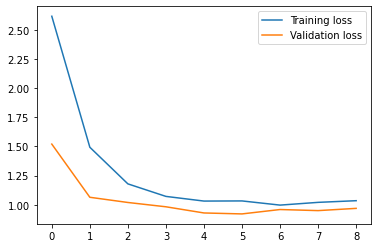

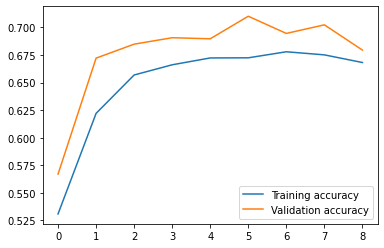

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])

## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_noisystudent_notop.h5',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])
opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (AdvProp)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
257/257 [==============================] - 248s 899ms/step - loss: 1.2167 - accuracy: 0.6249 - val_loss: 1.3165 - val_accuracy: 0.5884
Epoch 2/10
257/257 [==============================] - 228s 885ms/step - loss: 0.6792 - accuracy: 0.7755 - val_loss: 0.4822 - val_accuracy: 0.8412
Epoch 3/10
257/257 [==============================] - 228s 884ms/step - loss: 0.5328 - accuracy: 0.8144 - val_loss: 0.4057 - val_accuracy: 0.8500
Epoch 4/10
257/257 [==============================] - 228s 885ms/step - loss: 0.4390 - accuracy: 0.8491 - val_loss: 0.3761 - val_accuracy: 0.8670
Epoch 5/10
257/257 [==============================] - 227s 882ms/step - loss: 0.3649 - accuracy: 0.8703 - val_loss: 0.3465 - val_accuracy: 0.8792
Epoch 6/10
257/257 [==============================] - 227s 881ms/step - loss: 0.3260 - accuracy: 0.8840 - val_loss: 0.3427 - val_accuracy: 0.8738
Epoch 7/10
257/257 [==============================] - 227s 882ms/step - loss: 0.2811 - accuracy: 0.8995 - val_loss: 0.3215 -

2022/03/17 19:23:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


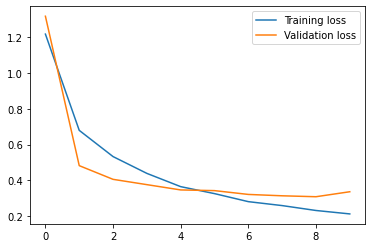

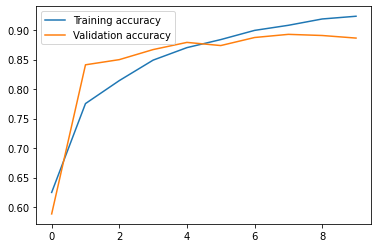

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10  9 10 ...  9  9 15]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_NoisyStudent.csv', index=False)
files.download('EfficientNetB2_NoisyStudent.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>